# test tika to convert documents in directory: category.
- Files directory in category is set in global_variables.py

# This program intends:
## Step 1
- To get multiple files in different formats, read text inside, even if it is pictures like jpog, tiff or png.<br>
- To clean all generic words that are not necessary to define metadatas<br>
- To remove duplicate metadata by file !<br>
- To generate a file with all metadatas found<br>
- To generate files named

 |name |description|
 |---|---|
 | **category__cloudword__lvl1.csv** | list of all metadata found on existing files in the directory, containing category and filenames |
 | **category_cloudword__dest1.csv** | list of all metadata found on existing files in the directory, without category and filenames. result to be used to draw a wordcloud |


<br>
## Step2
- To Get file with metadatas previously create<br>
- To remove first element of all lines (or to remove first column). Thsi column get the name of the source files of metadata.<br>
- to create a cloudwords with metadatas. More the same metadata exists in more file, more the size of the word wil be big<br>
<br>

### Note: Hot to Convert pdf to tiff
gs -o destination.tiff -r300 -sDEVICE=tiffg4 source.pdf
gs -o eos7d-mk2-im-tiffg4-1.tiff -r200x200  -sDEVICE=tiffg4 -sPAPERSIZE=a4 -dFirstPage=2 -dLastPage=99 eos7d-mk2-im-fr.pdf

In [1]:
import os
import shutil
from tika import parser
from datetime import datetime
import numpy as np
import pandas as pd
import re
import time
import psutil
import os
import signal
from sys import platform

#print(platform)

start_time = time.time()

In [2]:
import global_variables as g
g.init()

category=g.category

In [3]:
now = datetime.now()
 
parallelism =  4 

if g.DEBUG_OL >= 2:
    print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
#print("date and time =", dt_string)

#category="doc-engineering"
#category="doc-consoles"
#category="doc-electro"
#category="doc-photo"
#category="doc-airbus"
#category="doc-tests"
dirlist = os.listdir('../'+category)

#print(dirlist)
#for i in range(len(dirlist)):
#    dirlist[i]=''.join(dirlist[i].split())
    
if g.DEBUG_OL >= 1:
    print(len(dirlist),' fichiers à traiter\n', dirlist)

23  fichiers à traiter
 ['test14.odt', 'a380.odt', 'test51.odt', 'a3802pdf.tiff', 'test2.jpg', 'test5.odt', 'test1.png', 'test3.jpg', 'A330 -3.jpeg', 'a3802pdf.pdf', 'test13.odt', 'test1.odt', 'test12.odt', 'test9.tiff', 'test7.odt', 'test1.pdf', 'A330 -2.jpeg', 'test6.odt', 'test10.tiff', 'A330.jpeg', 'test7.pdf', 'test10.pdf', 'test11.docx']


------
# Retrieve unecessary words

In [4]:
#STOP_WORDS_FILE="stop_words_french.txt"
#STOP_WORDS_FILE="stop_words_english.txt"
STOP_WORDS_FILE="stop_all_words.txt"

with open(STOP_WORDS_FILE, 'r', encoding='UTF-8') as file:
    stop_words = file.read().splitlines()

if g.DEBUG_OL >= 2:
    print(stop_words)


In [5]:
output_directory=category+'_results'
message="le répertoire : "+output_directory+" va etre suprimé. Voulez-vous continuer [Y,n]"
attention = input(message)
if attention == "Y":
    try:
        shutil.rmtree(output_directory)
    except OSError as e:
        print("Error: %s : %s" % (output_directory, e.strerror))    
    os.mkdir(output_directory)

if g.DEBUG_OL >= 2:
    print(output_directory,' is created')
    
file_lvl1=output_directory+'/'+category+'__cloudword'+'__level1.csv'

le répertoire : doc-engineering_results va etre suprimé. Voulez-vous continuer [Y,n] Y


------
# Functions
## Retire les mots standards de la liste

In [6]:
def loop_check_stop_words(liste,word):
    a=1
    while a == 1:
        try:
            aaaa=liste.index(word)
            liste.pop(aaaa)
            if g.DEBUG_OL >= 2:
                print(liste)
        except:
            a = 0
    return(liste)

## Kill  le proces java utilisé par tika parser poru libérer de la mémoire à chaque fichier traité

In [7]:
def kill_linux_java_process():
    import psutil
    import os
    import signal

    PROCNAME = "java"
    aa=0
    bb=0
    for proc in psutil.process_iter():
        # check whether the process name matches
        if proc.name() == PROCNAME:
            aa=proc.pid
            if int(aa) > int(bb):
                bb=aa
    if g.DEBUG_OL >= 2:
        print(bb)
    os.kill(bb,signal.SIGTERM)
#    time.sleep(5)

## Converti le temps en heure, minute et secondes

In [8]:
def convert_to_preferred_format(sec):
    sec = sec % (24 * 3600)
    hour = sec // 3600
    sec %= 3600
    min = sec // 60
    sec %= 60
    if g.DEBUG_OL >= 2:
        print("seconds value in hours:",hour)
        print("seconds value in minutes:",min)
    return ("%02d:%02d:%02d") % (hour, min, sec)

## Creation d'une liste avec tous les mots clés trouvés dans les fichiers

In [9]:
my_full_liste=[]
start_func_time = time.time()
print("Lancement... Soyez patient...")
print('Traitement de ',len(dirlist),' fichiers')
compteur=0
for i in dirlist:
    df_file_wordcount=output_directory+'/'+category+'__'+i+'__wordscount.csv'
    if g.DEBUG_OL >= 1:
        print(i, 'En cours...')
    compteur +=1
    loop_time = time.time()
    xx=[]

    
    liste =[]
    str_match=[]
#    print("-----------------------\n",i)
    abspath = '../'+category
#    print(abspath)
    full_dir=os.path.abspath(abspath)
#    print(full_dir)
    aa=full_dir+'/'+i
    inode=os.stat(aa).st_ino
#    print(full_dir+'/'+i," en cours...")
    parsed_file = parser.from_file(aa,requestOptions=({'timeout': 1000}))
    my_metadata=parsed_file['metadata']
    my_content = parsed_file['content']
    if g.DEBUG_OL >= 2:
#        print('my_metadata:',my_metadata)
        print('my_content:',my_content)
       
    result = re.sub('[^A-Za-z0-9°éèàçùïœæ]+', ' ', my_content)
    result = result.replace('\n', '').lower()    

    #    my_content=my_content.replace('.',' ').replace(',',' ').replace('…',' ').replace('_',' ').replace('-',' ').replace(':',' ').replace('(','').replace(')','').replace('\"','')
#    result=' '.join(my_content.lower().split(' '))
 
#    if g.DEBUG_OL >= 2:
        #print('my_content:',my_content)
#    result=' '.join(my_content.lower().split())
    
#    result=result1.replace('\x00','\x0A')

    if g.DEBUG_OL >= 2:
        print('result:',result)
    liste = result.split()
    
    if g.DEBUG_OL >= 2:
        print('----->liste:',liste)

    for h in stop_words:
        try:
            liste=loop_check_stop_words(liste,h)
        except:
            pass

        
  
    liste1=list(set(liste)) # remove duplicate
    if g.DEBUG_OL >= 2:
        print(liste1)
    count_words = [liste.count(cw) for cw in liste1]
    if g.DEBUG_OL >= 2:
        print(cw,count_words)

    liste=liste1
    # save fiel with wordcounts
    df = pd.DataFrame(zip(liste, count_words), columns=['words','count'])
    df.sort_values('count', ascending=False, inplace=True)
    df.to_csv(df_file_wordcount,header=True,index=False,encoding='utf-8')
    
    jj =''.join(i.split())
    if g.DEBUG_OL >= 2:
        print(jj)
        print('liste avant:', liste)    
    liste.insert(0,jj) # Add file name as first element    
    liste.insert(0,category) # add category as second element
  
    if g.DEBUG_OL >= 2:
        print('liste: après',liste)
    if g.DEBUG_OL >= 1:
        print(compteur,' sur ',len(dirlist),' - fichier:',i, 'Terminé en %s seconds  '% (time.time() - loop_time))

    if g.DEBUG_OL >=2:
        print('---------->liste3:',liste,'\n---------\n')
    
    if platform == "linux" or platform == "linux2":
        kill_linux_java_process()
        time.sleep(2)

    my_full_liste.append(liste)

curr_time = time.time() - start_func_time
returned_time=convert_to_preferred_format(curr_time)

print('Processus terminé en,',returned_time[0:2],'heure(s)',returned_time[3:5],'minute(s)',returned_time[6:8],'seconds' )
       


Lancement... Soyez patient...
Traitement de  23  fichiers
test14.odt En cours...
1  sur  23  - fichier: test14.odt Terminé en 0.5009033679962158 seconds  
a380.odt En cours...
2  sur  23  - fichier: a380.odt Terminé en 0.5138511657714844 seconds  
test51.odt En cours...
3  sur  23  - fichier: test51.odt Terminé en 0.5266916751861572 seconds  
a3802pdf.tiff En cours...
4  sur  23  - fichier: a3802pdf.tiff Terminé en 2.9696266651153564 seconds  
test2.jpg En cours...
5  sur  23  - fichier: test2.jpg Terminé en 0.7873389720916748 seconds  
test5.odt En cours...
6  sur  23  - fichier: test5.odt Terminé en 0.5820882320404053 seconds  
test1.png En cours...
7  sur  23  - fichier: test1.png Terminé en 0.6378929615020752 seconds  
test3.jpg En cours...
8  sur  23  - fichier: test3.jpg Terminé en 0.600353479385376 seconds  
A330 -3.jpeg En cours...
9  sur  23  - fichier: A330 -3.jpeg Terminé en 0.607475757598877 seconds  
a3802pdf.pdf En cours...
10  sur  23  - fichier: a3802pdf.pdf Terminé en 

------
# Converti liste en fichier et compte le nombre de colonnes max

In [10]:
loop_time = time.time()

cloud_word_source = open(file_lvl1, 'w',encoding='utf-8')
if g.DEBUG_OL >= 2:
    print(my_full_liste)
print("Lancement...")
max_columns = 0
for k in my_full_liste:
    result=','.join(k)
    if g.DEBUG_OL >= 2:
        print(result)
    size=len(k)
    if g.DEBUG_OL >= 2:
        print(size)
    if size > max_columns:
        max_columns=size
    cloud_word_source.write(result)
    cloud_word_source.write('\x0A')
    if g.DEBUG_OL >= 1:
        print(k[1]," Traité !")
    if g.DEBUG_OL >= 2:
        print('max columns:',max_columns)
cloud_word_source.close()
if g.DEBUG_OL >= 1:
    curr_time = time.time() - loop_time
    returned_time=convert_to_preferred_format(curr_time)
    print('Processus terminé en,',returned_time[0:2],'heure(s)',returned_time[3:5],'minute(s)',returned_time[6:8],'seconds' )

print('***** Fini!! *****')

Lancement...
test14.odt  Traité !
a380.odt  Traité !
test51.odt  Traité !
a3802pdf.tiff  Traité !
test2.jpg  Traité !
test5.odt  Traité !
test1.png  Traité !
test3.jpg  Traité !
A330-3.jpeg  Traité !
a3802pdf.pdf  Traité !
test13.odt  Traité !
test1.odt  Traité !
test12.odt  Traité !
test9.tiff  Traité !
test7.odt  Traité !
test1.pdf  Traité !
A330-2.jpeg  Traité !
test6.odt  Traité !
test10.tiff  Traité !
A330.jpeg  Traité !
test7.pdf  Traité !
test10.pdf  Traité !
test11.docx  Traité !
Processus terminé en, 00 heure(s) 00 minute(s) 00 seconds
***** Fini!! *****


-------
# extrait les 2 premières colonnes du fichier pour enlever le noms des fichiers avant génération du nuage de mots

In [11]:
import pandas as pd
import numpy as np
print("Lancement... Soyez patient...")
input_file = file_lvl1
output_file = output_directory+'/'+category+'__cloudword'+'__dest1.csv'


col_headers= ['file']
for aa in range((max_columns)-1):
    col_headers.append('M'+str(aa))

if g.DEBUG_OL >= 2:
    print(col_headers)
    

my_loaded_array = pd.read_csv(input_file,dtype=str,header=None,names=col_headers,encoding='utf-8')

my_loaded_array=my_loaded_array.fillna('')
my_loaded_array

array_values = my_loaded_array.values
array_values

cloud_word_dest = open(output_file, 'w')
toto_values=array_values[:,2:]
#print(toto_values)

for k in range(len(toto_values)):
    if g.DEBUG_OL >= 2:
        print("k:",k,'\tligne:',toto_values[k,:])
    
    result=','.join(toto_values[k,:])
    if g.DEBUG_OL >= 2:
        print('result:',result)
    cloud_word_dest.write(result)
    cloud_word_dest.write('\x0A')
cloud_word_dest.close()

print('***** fichier:',output_file,' généré.') 

Lancement... Soyez patient...
***** fichier: doc-engineering_results/doc-engineering__cloudword__dest1.csv  généré.


In [12]:
curr_time = time.time() - start_time
returned_time=convert_to_preferred_format(curr_time)
print('Processus complet traité en,',returned_time[0:2],'heure(s)',returned_time[3:5],'minute(s)',returned_time[6:8],'seconds' )

Processus complet traité en, 00 heure(s) 01 minute(s) 10 seconds


------
# generate cloudwords

In [13]:
from wordcloud import WordCloud , ImageColorGenerator
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
MY_DPI = 96 # (site: https://fr.infobyip.com/detectmonitordpi.php)
image_mask = np.array(Image.open("airbus3.jpg"))
#print(matrix_image_mask)
if g.DEBUG_OL >= 2:
    print(image_mask.shape)
image_colors=ImageColorGenerator(image_mask)

In [14]:
def generate_cloud_words(TEXT_FILE_PATH):
    from wordcloud import WordCloud 
    import matplotlib.pyplot as plt
    # constantes
    MY_DPI = 96 # (site: https://fr.infobyip.com/detectmonitordpi.php)

#    TEXT_FILE_PATH='cloudword_source.txt'
    with open(TEXT_FILE_PATH, 'r') as file:
        text= file.read()
#    print(text)
    tmp_file=text.split('\n')
#    print(len(tmp_file)-1)

    STOP_WORDS_FILE="stop_words_french.txt"
    #STOP_WORDS_FILE="stop_words_english.txt"

    with open(STOP_WORDS_FILE, 'r') as file:
        stop_words = file.read().splitlines()
    
    wc = WordCloud(
        background_color="white",
        width =1920,
        height=1080,
        margin=10,
#        mask=image_mask,
#        max_words=100,
        stopwords=stop_words,
        repeat=False,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(1920/MY_DPI,1080/MY_DPI))


#    plt.imshow(wc.recolor(color_func=image_colors),interpolation='bilinear')
    plt.imshow(wc,interpolation='bilinear')
    plt.axis('off') # enleve les axes
    plt.margins(x=0, y=0)
    plt.savefig(output_directory+'/'+category+'__cloudword__dest1.png', dpi=MY_DPI)
    return(len(tmp_file)-1)

Nombre de fichiers traités: 23


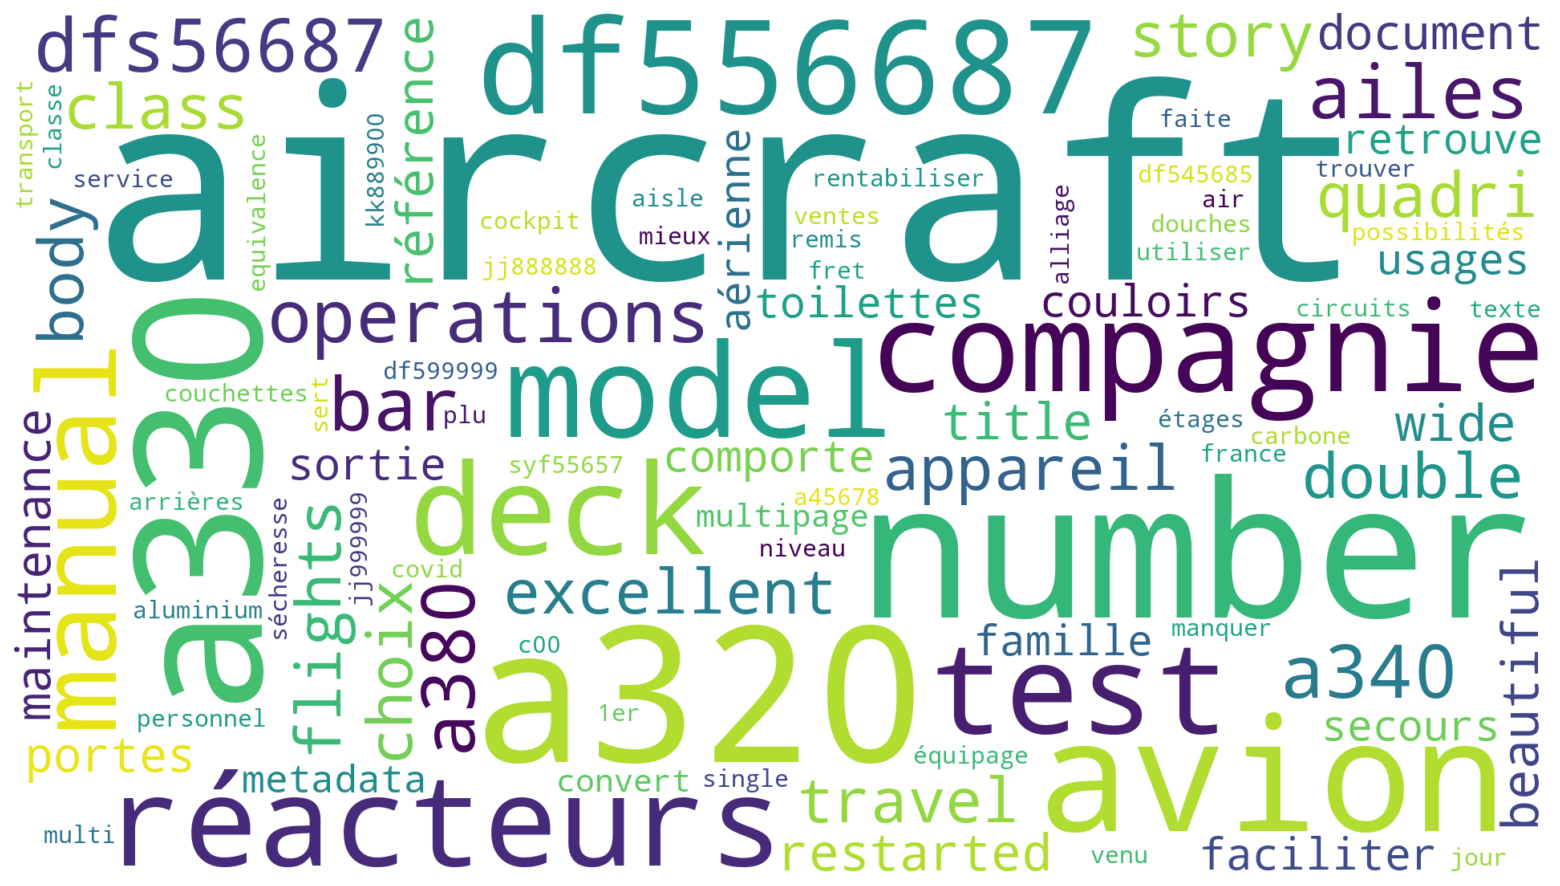

In [15]:
files_qtt=generate_cloud_words(output_file)
print("Nombre de fichiers traités:",files_qtt)

In [16]:
#if g.DEBUG_OL >= 1:
print(os.getcwd(),__name__,'imported')

/media/olivier/Donnees/Documents/Formations/tika2/jupyter_files __main__ imported
